In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from project_scripts.widgets import dataset_movie_widget
from project_scripts.analyze import plot_training_curves, model_uncertainty, cancer_segmentation
from project_scripts.data_loading import load_dataset, slices_to_textures, dataset_to_embeddings
from project_scripts.neural_networks import B_frame_CNN, texture_CNN

In [2]:
X_test, Y_test, _, _ = load_dataset('testing_data')
X_test_textures = slices_to_textures(X_test)
X_test_embeddings = dataset_to_embeddings(X_test, X_test_textures)

LOADING: directory=(testing_data) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(testing_data\cancer) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(testing_data\cancer\6-08-2017-s2) | label=([1, 0]) | total_bframes=(19)
LOADING: directory=(testing_data\cancer\6-24-2019-s2) | label=([1, 0]) | total_bframes=(68)
LOADING: directory=(testing_data\non_cancer) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(testing_data\non_cancer\8-24-2017-C1-s4) | label=([0, 1]) | total_bframes=(91)
LOADING: directory=(testing_data\non_cancer\8-24-2017-C2-s2) | label=([0, 1]) | total_bframes=(52)
51/51 [==============================] - 0s 2ms/step


In [3]:
print('TESTING DATA')
print(f'(num_slices, slice_height, slice_width, slice_channels): {X_test.shape}')
print(f'(num_textures, texture_height, texture_width, texture_channels): {X_test_textures.shape}')
print(f'(num_embeddings, len_embedding): {X_test_embeddings.shape}')
print(f'(num_labels, #_classes): {Y_test.shape} \n')

dataset_movie_widget(X_test_textures, Y_test)

TESTING DATA
(num_slices, slice_height, slice_width, slice_channels): (1610, 200, 100)
(num_textures, texture_height, texture_width, texture_channels): (1610, 100, 100, 1)
(num_embeddings, len_embedding): (1610, 128)
(num_labels, #_classes): (1610, 2) 



interactive(children=(Play(value=0, description='idx', interval=500, max=1609), IntSlider(value=0, description…

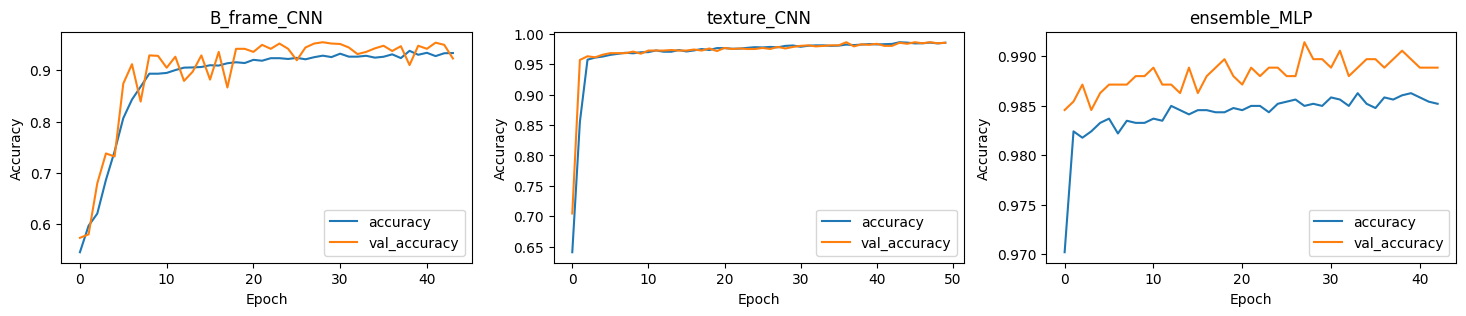

In [5]:
plt.subplots(1,3, figsize=(18,3))
plt.subplot(1,3,1)
plot_training_curves('saved_models\\final_models\\logs\\bframe_cnn_log.csv', 'B_frame_CNN')
plt.subplot(1,3,2)
plot_training_curves('saved_models\\final_models\\logs\\texture_cnn_log.csv', 'texture_CNN')
plt.subplot(1,3,3)
plot_training_curves('saved_models\\final_models\\logs\\ensemble_mlp_log.csv', 'ensemble_MLP')
plt.show()

In [7]:
print('-- B_frame_CNN --')
model_uncertainty('saved_models\\final_models\\bframe_cnn', np.expand_dims(X_test, axis=3), Y_test)

print('-- texture_CNN --')
model_uncertainty('saved_models\\final_models\\texture_cnn', X_test_textures, Y_test)

print('-- ensemble_MLP --')
model_uncertainty('saved_models\\final_models\\ensemble_mlp', X_test_embeddings, Y_test)

B_frame_CNN --
mu_acc: 85.031%, std_acc: 0.533%, mu_sens: 94.976%, std: 74.056%
mu_acc: 94.273%, std_acc: 0.181%, mu_sens: 97.666%, std: 89.349%
mu_acc: 94.056%, std_acc: 0.176%, mu_sens: 98.006%, std: 88.474%


(0.9405590062111802,
 0.0017578846829919034,
 0.9800619373766913,
 0.8847386087344346)

In [6]:
X_margin, _, _, _ = load_dataset('margin_data\\4-12-2021-WM2-0', step=1)
X_margin_textures = slices_to_textures(X_margin)
X_margin_embeddings = dataset_to_embeddings(X_margin, X_margin_textures)

LOADING: directory=(margin_data\4-12-2021-WM2-0) | label=([0, 1]) | total_bframes=(256)
160/160 [==============================] - 0s 1ms/step


In [12]:
print('MARGIN DATA')
print(f'(num_slices, slice_height, slice_width, slice_channels): {X_margin.shape}')
print(f'(num_textures, texture_height, texture_width, texture_channels): {X_margin_textures.shape}')
print(f'(num_embeddings, len_embedding): {X_margin_embeddings.shape}')

MARGIN DATA
(num_slices, slice_height, slice_width, slice_channels): (5120, 200, 100)
(num_textures, texture_height, texture_width, texture_channels): (5120, 100, 100, 1)
(num_embeddings, len_embedding): (5120, 128)


160/160 [==============================] - 0s 1ms/step


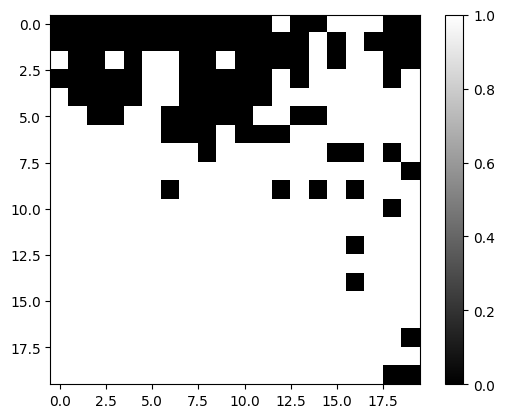

In [7]:
# cancer_segmentation(np.expand_dims(X_margin, axis=3), 'saved_models\\final_models\\bframe_cnn')
# cancer_segmentation(X_margin_textures, 'saved_models\\final_models\\texture_cnn')
cancer_segmentation(X_margin_embeddings, 'saved_models\\final_models\\ensemble_mlp')

In [32]:
from skimage.transform import resize
import ipywidgets as widgets

'''
Code adapted from: https://keras.io/examples/vision/grad_cam/
'''
def make_heatmap(input, model, is_texture=False):
    with tf.GradientTape() as tape:
        if(is_texture):
            last_conv_layer_output, preds = model(np.reshape(input, (1,100,100,1)))
        else: 
            last_conv_layer_output, preds = model(np.reshape(input, (1,200,100,1)))

        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

def plot_gradcam(idx, X_slices, X_textures, Y_data, bframe_model_fpath, texture_model_fpath):
    model3 = B_frame_CNN(3, 'relu', 'same')
    model4 = texture_CNN(3, 'relu', 'same')
    model3.load_weights(bframe_model_fpath).expect_partial()
    model4.load_weights(texture_model_fpath).expect_partial()
    bframe_gradcam = model3.get_gradcam()
    texture_gradcam = model4.get_gradcam()

    bframe_pred = model3.predict(np.reshape(X_slices[idx], (1,200,100,1)))[0] > 0.5
    texture_pred = model4.predict(np.reshape(X_textures[idx], (1,100,100,1)))[0] > 0.5
    bframe_heat_map = make_heatmap(X_slices[idx], bframe_gradcam)
    texture_heat_map = make_heatmap(X_textures[idx], texture_gradcam, is_texture=True)

    plt.subplots(1,2, figsize=(6,3))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(X_textures[idx], cmap='gray')
    plt.imshow(resize(texture_heat_map, (100,100)), cmap='jet', alpha=0.2)
    plt.title(f'{texture_pred}')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(X_slices[idx], cmap='gray')
    plt.imshow(resize(bframe_heat_map, (200,100)), cmap='jet', alpha=0.2)
    plt.title(f'{bframe_pred}')
    plt.colorbar()
    plt.show()

widgets.interactive(plot_gradcam,
                    idx = widgets.IntSlider(max=X_test.shape[0]-1),
                    X_slices = widgets.fixed(X_test),
                    X_textures = widgets.fixed(X_test_textures),
                    Y_data = widgets.fixed(Y_test),
                    bframe_model_fpath = widgets.fixed('saved_models\\final_models\\bframe_cnn'),
                    texture_model_fpath = widgets.fixed('saved_models\\final_models\\texture_cnn'))

interactive(children=(IntSlider(value=0, description='idx', max=1609), Output()), _dom_classes=('widget-intera…